<a href="https://colab.research.google.com/github/emshg/kiva_funding/blob/main/CIS545_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIS545 GROUP PROJECT
By Emily Shang, Shirley Shi, Eric Xu

Dec / 15 / 2022

##**Project Background**


### Project Description
[Kiva](https://www.kaggle.com/datasets/kiva/data-science-for-good-kiva-crowdfunding?select=loan_theme_ids.csv) brings together researchers and students to develop localized models to prdeict the poverty levels in the areas where Kiva's users live.
In support of Kiva's misssion to provide crowdfunding serivce in regions with poverty, we are developing models to predict the loan amount based on the given dataset. The prediction of the borrowing amount for the loan application helps to provide a reference for Kiva lenders. Ideally, Kiva lenders can make loans based on a forecasted borrowing amount. The prediction of the loan amount can not only reduce the information asymmetry between the lender and the borrower but also improve the service quality of the Kiva platform.


### Problem Statement
Kiva provides four datasets that include the loan features, the demographic characteristics of the borrowers, and the economic information of the area where the borrowers are located. By Kiva's data and external data sources, we can make predictions about loan amounts.

### Project Objectives
In order to help Kiva provide better financial services in regions with high poverty levels and reduce information asymmetry between borrowers and lenders, this project will develop useful models to predict loan amounts or loan amounts divided into multiclass. We will apply Linear Regression, Logistic Regression, and Random Forest to forecast the loan amount for each loan.

##**Imports & Set Up**

In [ ]:
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import torch.utils.data as data_utils
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from matplotlib import cm
from matplotlib import dates as mdates
from matplotlib.lines import Line2D
from google.colab import drive
from urllib.parse import unquote
import plotly.express as px
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
from wordcloud import WordCloud
import torch.nn as nn
import torch


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

We will use Kaggle API to import our Kiva datasets. You might need a kaggle.json file in your drive and authorize Google Drive access.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!cp /content/drive/Shareddrives/kiva_region_stats/country_stats.csv /content/
!cp /content/drive/Shareddrives/kiva_region_stats/MPI_national.csv /content/
!cp /content/drive/Shareddrives/kiva_region_stats/MPI_subnational.csv /content/
!cp /content/drive/Shareddrives/kiva_region_stats/loan_coords.csv /content/
!cp /content/drive/Shareddrives/kiva_region_stats/locations.csv /content/

In [ ]:
!!kaggle datasets download -d kiva/data-science-for-good-kiva-crowdfunding

['data-science-for-good-kiva-crowdfunding.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip /content/data-science-for-good-kiva-crowdfunding.zip

Archive:  /content/data-science-for-good-kiva-crowdfunding.zip
replace kiva_loans.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace kiva_mpi_region_locations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace loan_theme_ids.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace loan_themes_by_region.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


##**Load DataSet & Description**

Let's load our dataset from [Kiva Datasciene for Good challenge](https://www.kaggle.com/datasets/kiva/data-science-for-good-kiva-crowdfunding?select=loan_theme_ids.csv)
We will work with 4 datasets mainly.
Let's introduce each dataset:


*   **loans_df:** This is the main dataset we will be working with. It has:

    *   loan id
    *   requested / funded amounts
    *   post/disbursed / funded dates
    *   lenders count
    *   borrower gender(s)
    *   usage of the loan
    *   country (ISO) where loan disbursed

*   **theme_df:** This would be an auxiliary dataset to use with loans_df to provide info for loan themes (the purpose of the loan). It has:
    *   loan id
    *   theme id
    *   theme type
    *   field partner id

*   **theme_reg_df:** This would be an auxiliary dataset. We will mainly use its regional and economic data. It has:
    *   loan id
    *   country
    *   region
    *   ISO
    *   MPI region

*   **mpi_df:** This would be an auxiliary dataset to use with theme_reg_df. It provides regional MPI (multidimensional poverty index) that tells the economic status of the borrowers. It has: 
    *   country
    *   region
    *   ISO
    *   MPI





In [ ]:
loans_df = pd.read_csv('kiva_loans.csv')

In [ ]:
theme_df = pd.read_csv('loan_theme_ids.csv')

In [ ]:
theme_reg_df = pd.read_csv('loan_themes_by_region.csv', encoding = "ISO-8859-1")

In [ ]:
mpi_df = pd.read_csv('kiva_mpi_region_locations.csv')

In [ ]:
mpi_national_df = pd.read_csv('MPI_national.csv')

In [ ]:
mpi_subnational_df = pd.read_csv('MPI_subnational.csv')

In [ ]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

In [ ]:
loans_df.info()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01
5,1080148,250.0,250.0,Services,Services,purchase leather for my business using ksh 20000.,KE,Kenya,NaN,KES,NaN,2014-01-01 10:06:19+00:00,2014-01-30 01:42:48+00:00,2014-01-29 14:14:57+00:00,4.0,6,NaN,female,irregular,2014-01-01
6,653067,200.0,200.0,Dairy,Agriculture,To purchase a dairy cow and start a milk produ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:51:02+00:00,2013-12-16 08:00:00+00:00,2014-01-01 17:18:09+00:00,43.0,8,"user_favorite, user_favorite",female,bullet,2014-01-01
7,653078,400.0,400.0,Beauty Salon,Services,to buy more hair and skin care products.,PK,Pakistan,Ellahabad,PKR,245.0,2014-01-01 11:46:01+00:00,2013-12-20 08:00:00+00:00,2014-01-10 18:18:44+00:00,14.0,8,"#Elderly, #Woman Owned Biz",female,monthly,2014-01-01
8,653082,475.0,475.0,Manufacturing,Manufacturing,"to purchase leather, plastic soles and heels i...",PK,Pakistan,Lahore,PKR,245.0,2014-01-01 11:49:43+00:00,2013-12-20 08:00:00+00:00,2014-01-01 18:47:21+00:00,14.0,19,user_favorite,female,monthly,2014-01-01
9,653048,625.0,625.0,Food Production/Sales,Food,"to buy a stall, gram flour, ketchup, and coal ...",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 05:41:03+00:00,2013-12-17 08:00:00+00:00,2014-01-03 15:45:04+00:00,11.0,24,NaN,female,irregular,2014-01-01


In [ ]:
mpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LocationName  984 non-null    object 
 1   ISO           1008 non-null   object 
 2   country       1008 non-null   object 
 3   region        984 non-null    object 
 4   world_region  1008 non-null   object 
 5   MPI           984 non-null    float64
 6   geo           2772 non-null   object 
 7   lat           892 non-null    float64
 8   lon           892 non-null    float64
dtypes: float64(3), object(6)
memory usage: 195.0+ KB


In [ ]:
theme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               779092 non-null  int64  
 1   Loan Theme ID    764279 non-null  object 
 2   Loan Theme Type  764279 non-null  object 
 3   Partner ID       764279 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


As we notice that our MPI data appears null for numerous loan cases and that it solely might be an inadequate measure of the borrower/lender's welfare status, we decided to add country/region stats to add more data for our analysis.

The country stats dataset provides more measures of country status (population, life expectancy, education etc.) to provide us possible insights for prediction on loan requests.

In [ ]:
country_stats = pd.read_csv('country_stats.csv')

In [ ]:
loan_locations = pd.read_csv('locations.csv')

In [ ]:
loan_coords = pd.read_csv('loan_coords.csv')

In [ ]:
country_stats.head(5)

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh


In [ ]:
loan_coords.head(5)

,loan_id,latitude,longitude
0,657307,8.162411,123.774119
1,673156,8.162411,123.774119
2,888943,8.162411,123.774119
3,613323,8.162411,123.774119
4,777937,8.162411,123.774119


In [ ]:
loan_locations.head(5)

,address_components,formatted_address,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,location_name,partial_match,place_id,types
0,"[{'long_name': 'Managua', 'short_name': 'Manag...","Managua, Nicaragua",12.175357,-86.125088,12.019961,-86.391833,12.114993,-86.236174,APPROXIMATE,12.175357,-86.125088,12.019961,-86.391833,"Managua, Nicaragua",NaN,ChIJC4gH2Q1WcY8RakxPFKL0Xmw,"['locality', 'political']"
1,"[{'long_name': 'Lahore', 'short_name': 'Lahore...","Lahore, Pakistan",31.698486,74.587397,31.267394,74.115539,31.520370,74.358747,APPROXIMATE,31.698486,74.587397,31.267394,74.115539,"Lahore, Pakistan",NaN,ChIJ2QeB5YMEGTkRYiR-zGy-OsI,"['locality', 'political']"
2,"[{'long_name': 'Kaduna', 'short_name': 'Kaduna...","Kaduna, Nigeria",10.616996,7.508812,10.397157,7.349789,10.510464,7.416505,APPROXIMATE,10.616996,7.508812,10.397157,7.349789,"Kaduna, Nigeria",NaN,ChIJdRc3NFg1TRARdOG_mpeVAUg,"['locality', 'political']"
3,"[{'long_name': 'Cusco', 'short_name': 'Cusco',...","Cusco, Peru",-13.497391,-71.853332,-13.562648,-72.025166,-13.531950,-71.967463,APPROXIMATE,-13.497391,-71.853332,-13.562648,-72.025166,"Cusco, Peru",NaN,ChIJMYRZJtjVbZERXTEYI8yWqSo,"['locality', 'political']"
4,"[{'long_name': 'León', 'short_name': 'León', '...","León, Nicaragua",12.460966,-86.843405,12.407026,-86.920753,12.431553,-86.872215,APPROXIMATE,12.460966,-86.843405,12.407026,-86.920753,"Leon, Nicaragua",NaN,ChIJd3qPu5IfcY8RPDHqZG_AtTo,"['locality', 'political']"


##**Data Cleaning & Preprocessing**

####**loans_df and theme_df**
There are several columns in loan and theme data that are repetitive. Let's drop them for better performance in later analysis.

We would also analyse the relationships between features in both dataset, and it would be appropriate to join them on shared loan id.

####**MPI and Location Data (mpi_reg_df)**
mpi_df might be the dataframe that has the most nulls, as mpi is not available for every region. Since it would also be extremely challenging to recover/mock any MPI, which is the main feature we are interested in in this dataframe, we would simply drop the datapoints where mpi is not availavle.

On the contrary, theme_reg_df has more coverage of regional data for loans, which we will merge with mpi_df to generalize mpi data to more loan instances. We will also use location data mainly from theme_reg_df.

In [ ]:
# Drop Nulls in mpi_df and save as mpi_df_cl
mpi_df_cl = mpi_df.dropna()
mpi_df_cl.head(10)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210
5,"Daykundi, Afghanistan",AFG,Afghanistan,Daykundi,South Asia,0.313,"(33.669495, 66.0463534)",33.669495,66.046353
6,"Farah, Afghanistan",AFG,Afghanistan,Farah,South Asia,0.319,"(32.4464635, 62.1454133)",32.446464,62.145413
7,"Faryab, Afghanistan",AFG,Afghanistan,Faryab,South Asia,0.250,"(36.0795613, 64.90595499999999)",36.079561,64.905955
8,"Ghazni, Afghanistan",AFG,Afghanistan,Ghazni,South Asia,0.245,"(33.5450587, 68.4173972)",33.545059,68.417397
9,"Ghor, Afghanistan",AFG,Afghanistan,Ghor,South Asia,0.384,"(34.0995776, 64.90595499999999)",34.099578,64.905955


Note that here, we are using theme_reg_df mainly to apply MPI to actual regions and countries, therefore we are not interested in its data about themes and loan specific info. Therefore, we will drop duplicates and only keep one loan for each region.

In [ ]:
# Drop duplicates in theme_reg_df to extract only MPI relevant info
theme_reg_unq = theme_reg_df.drop_duplicates(subset=['region'], ignore_index = True)

In [ ]:
# Merge mpi_df_cl and theme_reg_unq_df into mpi_reg_df that contains both location and mpi data
mpi_reg_df = theme_reg_unq[['ISO', 'country','region','geo', 'Loan Theme ID']].merge(mpi_df_cl[['MPI', 'ISO']], \
                                                         left_on=['ISO'], right_on=['ISO'], how='inner')

In [ ]:
mpi_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100091 entries, 0 to 100090
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ISO            100091 non-null  object 
 1   country        100091 non-null  object 
 2   region         100091 non-null  object 
 3   geo            100091 non-null  object 
 4   Loan Theme ID  100091 non-null  object 
 5   MPI            100091 non-null  float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


####**Loans and Theme Data (loan_theme_df)**
Aside from location and MPI data, the other major aspects of the data we will analyse are **loans** and their **themes**.
Let's join loans_df with theme_df on ther shared loan id.

But first, let's drop some columns in loans_df that has many nulls/overlap with other cols and that we won't be using:
*   tags --- we are not interested in the tags column
*   date --- we will use the post_date column instead of the date column to avoid ambiguity
*   partner_id --- we won't be analysing partner data (or maybe if we have time)

We would also want to re-format the time columns (posted_time, disbursed_time, funded_time) into datetime data before merge.



In [ ]:
# drop the 3 columns (and nulls) and save as loans_df_cl
loans_df_cl = loans_df.drop(columns=['tags', 'date', 'partner_id'])
theme_df_cl = theme_df.drop(columns=['Partner ID'])
loans_df_cl = loans_df_cl.dropna()

In [ ]:
# save in new columns the datetime formate posted, disbursed, and, funded time columns
loans_df_cl['posted_date'] = loans_df_cl['posted_time'].apply(lambda x: dt.datetime.strptime(x[:10], "%Y-%m-%d"))
loans_df_cl['disbursed_date'] = loans_df_cl['disbursed_time'].apply(lambda x: dt.datetime.strptime(x[:10], "%Y-%m-%d"))
loans_df_cl['funded_date'] = loans_df_cl['funded_time'].apply(lambda x: dt.datetime.strptime(x[:10], "%Y-%m-%d"))

**Note on date data:** most of our models might not be very compatible with date data, but we could now use these data to generate two new features: **fund_time** and **disburse_time** that represents the time taken for a loan to be funded / disbursed.

fund_time represents the time taken for a fund to be fulfilled after it was posted.

disburse_time represents the time lapse between when fund is fulfilled and when the borrower got the fund.

In [ ]:
loans_df_cl['fund_time'] = (loans_df_cl['funded_date']-loans_df_cl['posted_date'])
loans_df_cl['fund_time'] = loans_df_cl['fund_time'].apply(lambda x : x.days)
loans_df_cl['disburse_time'] = loans_df_cl['disbursed_date']-loans_df_cl['funded_date']
loans_df_cl['disburse_time'] = loans_df_cl['disburse_time'].apply(lambda x : x.days)

It is important to note that loans are often disbursed by Kiva partners, who may disburse the fund first to the borrower and then post the request on Kiva for a fund, for more timely funding. Therefore, disbursement does not necessarily happen after funding is fulfilled, and disburse_time could be negative.

With this in mind, we can add another feature that represents whether the disbursement happened before funding is collected (so negative disburse_time), which might give us a sense of the funding experience.

In [ ]:
loans_df_cl['disburse_before_fund'] = loans_df_cl['disburse_time'].apply(lambda x : 1 if x <= 0 else 0)

In [ ]:
# we can then drop the 3 time columns as no longer needed
loans_df_cl = loans_df_cl.drop(columns=['posted_time', 'disbursed_time', 'funded_time'])

In [ ]:
# join loans_df and theme_df and save as loan_theme_df
loan_theme_df = loans_df_cl.merge(theme_df_cl, left_on='id', right_on='id', how='inner')

####Loans, Theme, MPI, and Welfare Metrics
Now we want to add more stats of the regions and countries of these loan records. We will derive these from the country_stats and mpi_national_df dataframes that contain mpi and other life welfare metrics of different regions and countries.

We will merge these datasets by country_name, as the country_code has a column that contains specifically country names corresponding to the Kiva dataset.

In [ ]:
loan_theme_loc_df = loan_theme_df.merge(loan_coords, left_on=['id'], right_on=['loan_id']).drop(columns=['loan_id'])
loan_theme_loc_df = loan_theme_df.merge(country_stats, on=['country_code'])

Now that our main dataset has shared country codes with the mpi_national_df dataset, we can use it to merge these two datasets.

In [ ]:
loan_theme_stats_df = mpi_national_df.merge(loan_theme_loc_df, left_on=['ISO'], right_on=['country_code3'], how='right')

In [ ]:
loan_theme_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574090 entries, 0 to 574089
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   ISO                             537158 non-null  object        
 1   Country                         537158 non-null  object        
 2   MPI Urban                       537158 non-null  float64       
 3   Headcount Ratio Urban           537158 non-null  float64       
 4   Intensity of Deprivation Urban  537158 non-null  float64       
 5   MPI Rural                       537158 non-null  float64       
 6   Headcount Ratio Rural           537158 non-null  float64       
 7   Intensity of Deprivation Rural  537158 non-null  float64       
 8   id                              574090 non-null  int64         
 9   funded_amount                   574090 non-null  float64       
 10  loan_amount                     574090 non-null  float64

Now we have both national and regional MPI data in our dataset, though it is noticeable that there are a lot of nulls in the regional metrics because not all regions have these meatures.

To make the most efficient representative data, let's update values in national mertics with regional ones if available.

#### Finalizing loan_stats_df

Now we are mostly done with merging the columns, it appears that there are redundant columns and differences between number of non-null values in our current dataset. Let's clean it up finally.

First is that we have some nulls in the country welfare metrics that do not match the number of data we have for other features. In our case, since we have fairly large sample size and that the nulls are a result of merging (as supposed to bias), we would decide to drop any row that has a column with null for later analysis.

In [ ]:
loan_stats_df = loan_theme_stats_df.dropna(subset=['ISO', 'population_below_poverty_line']).reset_index().drop(columns=['index'])
loan_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537083 entries, 0 to 537082
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   ISO                             537083 non-null  object        
 1   Country                         537083 non-null  object        
 2   MPI Urban                       537083 non-null  float64       
 3   Headcount Ratio Urban           537083 non-null  float64       
 4   Intensity of Deprivation Urban  537083 non-null  float64       
 5   MPI Rural                       537083 non-null  float64       
 6   Headcount Ratio Rural           537083 non-null  float64       
 7   Intensity of Deprivation Rural  537083 non-null  float64       
 8   id                              537083 non-null  int64         
 9   funded_amount                   537083 non-null  float64       
 10  loan_amount                     537083 non-null  float64

#### Preprocessing for Modeling - Encoding & Cleaning
It is noticeable that our data contains a fair number of non-numeric features, so in this section we will try to encode some of them to numeric values for modeling.


#####**Categroical to Numeric: Encoding**

There are a few categorical features that we would want to convert to numeric values via one hot encoding:
- sector: the broader categories of the loan request; has 15 distinct values.
- repayment_interval: how the loan was repaid; has 3 types.

Note that the other categorical values are either addressable with numeric features or were used to merge numeric features (e.g. we used country codes to get national MPI, but not necessarily interested in analysing with country codes).

In [ ]:
loan_stats_ml = loan_stats_df.select_dtypes(exclude=['datetime64'])
loan_stats_ml = loan_stats_ml.drop(columns=['ISO', 'Country', 'activity', 'use', \
                                            'country_code', 'country', 'region_x', 'currency','borrower_genders', \
                                            'Loan Theme ID', 'Loan Theme Type', 'country_name', 'country_code3',\
                                            'continent', 'id'])

In [ ]:
loan_stats_ml = pd.get_dummies(loan_stats_ml, columns = ['repayment_interval', 'sector'], prefix=['repayment_interval', 'sector'])

In [ ]:
loan_stats_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537083 entries, 0 to 537082
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MPI Urban                       537083 non-null  float64
 1   Headcount Ratio Urban           537083 non-null  float64
 2   Intensity of Deprivation Urban  537083 non-null  float64
 3   MPI Rural                       537083 non-null  float64
 4   Headcount Ratio Rural           537083 non-null  float64
 5   Intensity of Deprivation Rural  537083 non-null  float64
 6   funded_amount                   537083 non-null  float64
 7   loan_amount                     537083 non-null  float64
 8   term_in_months                  537083 non-null  float64
 9   lender_count                    537083 non-null  int64  
 10  fund_time                       537083 non-null  int64  
 11  disburse_time                   537083 non-null  int64  
 12  disburse_before_

## **EDA**

After some data cleaning and preprocessing, we have two ready-to-use datesets to work on, namely **loan_theme_df** and **mpi_reg_df**. We will explore and understand our data more in this section.

Note that the main aspects covered in these datesets are:


*   Loan stats (amount, borrower / lender info, dates)
*   Loan themes (activity, use)
*   Loan and MPI geographic distribution (where loans are requested, lent, and spent)

We will do our EDA into these 3 directions.

### Loan Stats 

In [ ]:
#check unique values of sector
sector_unique=np.unique(loan_theme_df['sector'].tolist())

There are too many sectors in this case, hence, we move forward with other feature.

The distribution of loan demand

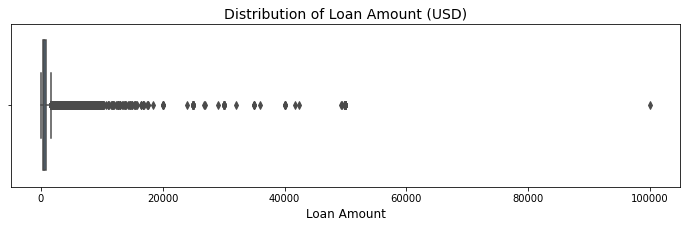

In [ ]:
plot = plt.figure(figsize=(12,3))
sns.boxplot(x=loan_stats_df['loan_amount'], color='steelblue')
_=plt.xlabel('Loan Amount', fontsize=12)
_=plt.title("Distribution of Loan Amount (USD)", fontsize=14)
_=plt.xticks(fontsize=10)

Plot the country counts distribution and avg funded amount.

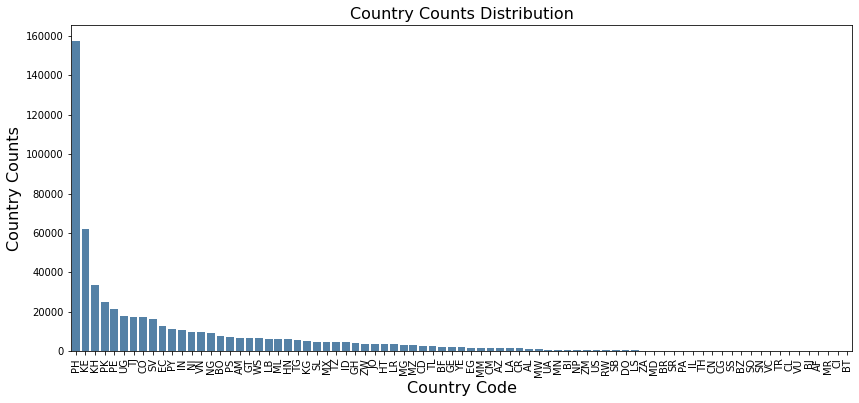

In [ ]:
#check unique values of country_code
country_code_unique=np.unique(loan_theme_df['country_code'].tolist())
country_code_counts=loan_theme_df['country_code'].value_counts()
#plot the country counts distribution
plot = plt.figure(figsize=(14,6))
sns.barplot(x = country_code_counts.index, y=country_code_counts.values, color='steelblue')
plt.xlabel('Country Code', fontsize=16)
plt.ylabel("Country Counts", fontsize=16)
plt.title("Country Counts Distribution", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.show();

According to the Country Code plot, the first 10 countries with most country counts cover the most of the dataset. Then, we want to see if there is any connection between the first 10 countries with most country counts and the first 10 countries with most average funded amount.

In [ ]:
#table of the first 10 countries with most average funded amount
country_top = loan_theme_df[['country_code','funded_amount']]
country_top = country_top.groupby(by=['country_code'], as_index=False).mean()
country_top = country_top.rename(columns={"funded_amount": "avg_funded_amount"})
country_top = country_top.sort_values(by='avg_funded_amount', ascending=False).head(10)
country_top

,country_code,avg_funded_amount
13,CI,50000.000000
6,BJ,25150.000000
43,MR,15000.000000
9,BT,10000.000000
14,CL,8080.555556
0,AF,7000.000000
12,CG,6142.578125
72,US,4709.189580
19,DO,4254.725275
28,IL,3805.277778


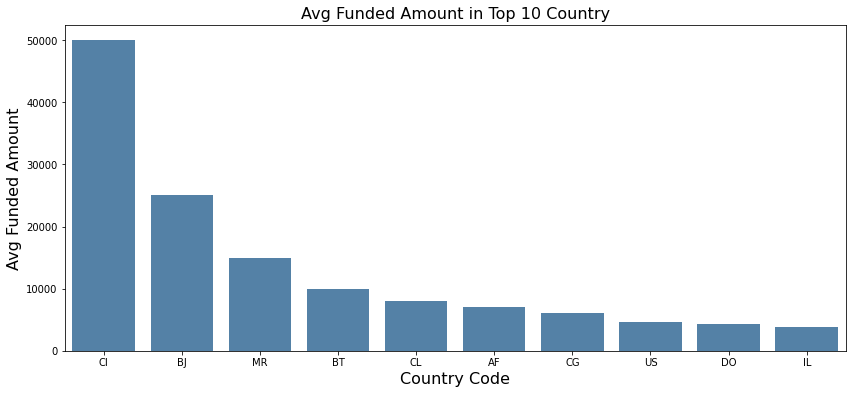

In [ ]:
#plot the avg funded amount
plot = plt.figure(figsize=(14,6))
sns.barplot(x = 'country_code', y='avg_funded_amount', color='steelblue', data=country_top)
plt.xlabel('Country Code', fontsize=16)
plt.ylabel("Avg Funded Amount", fontsize=16)
plt.title("Avg Funded Amount in Top 10 Country", fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.show();

According to the result, there is a huge difference between the first 10 countries with most country counts and the first 10 countries with most average funded amount.

Check unique values of	repayment interval

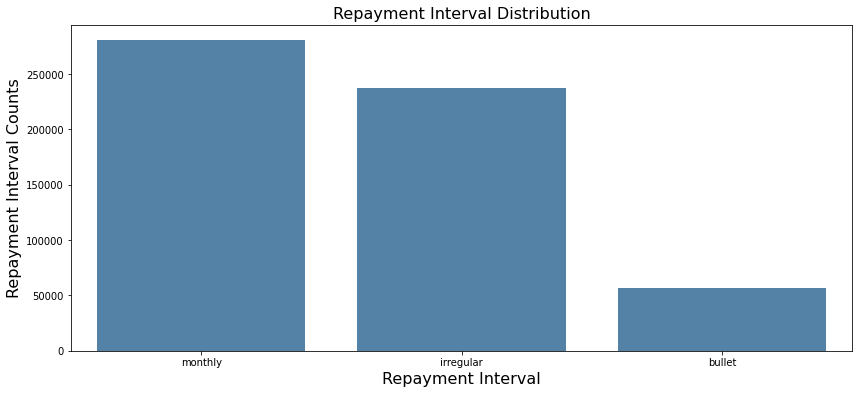

In [ ]:
#check unique values of	repayment_interval
#np.unique(loan_theme_df['repayment_interval'].tolist())
repayment_interval_counts=loan_theme_df['repayment_interval'].value_counts()
#plot
plot = plt.figure(figsize=(14,6))
sns.barplot(x = repayment_interval_counts.index, y=repayment_interval_counts.values, color='steelblue')
plt.xlabel('Repayment Interval', fontsize=16)
plt.ylabel("Repayment Interval Counts", fontsize=16)
plt.title("Repayment Interval Distribution", fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.show();

In [ ]:
#check unique values of Loan Theme Type
loan_theme_type=np.unique(loan_theme_df['Loan Theme Type'].tolist())

There are too many classes, therefore, we move forward with other columns.

Check the correlation matrix.

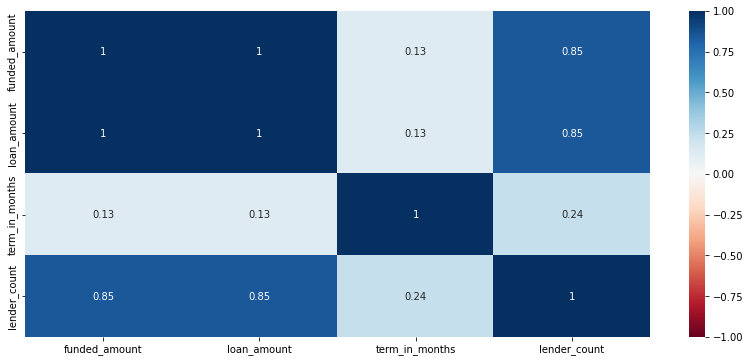

In [ ]:
numerics_df = loan_theme_df[['funded_amount','loan_amount','term_in_months','lender_count']]
plt.figure(figsize=(14,6))
corr_matrix = numerics_df.corr()    
sns.heatmap(corr_matrix, cmap="RdBu",vmin=-1, vmax=1,annot=True)

We found that funded_amount, loan_amount and lender_count are highly correlated.

### Loan and MPI geographic distribution

Plot the ISO counts distribution and avg MPI.

In [ ]:
mpi_reg_df.head()

,ISO,country,region,geo,Loan Theme ID,MPI
0,KHM,Cambodia,Banteay Meanchey,"(13.6672596, 102.8975098)",a1050000000slfi,0.097
1,KHM,Cambodia,Banteay Meanchey,"(13.6672596, 102.8975098)",a1050000000slfi,0.160
2,KHM,Cambodia,Banteay Meanchey,"(13.6672596, 102.8975098)",a1050000000slfi,0.193
3,KHM,Cambodia,Banteay Meanchey,"(13.6672596, 102.8975098)",a1050000000slfi,0.182
4,KHM,Cambodia,Banteay Meanchey,"(13.6672596, 102.8975098)",a1050000000slfi,0.183


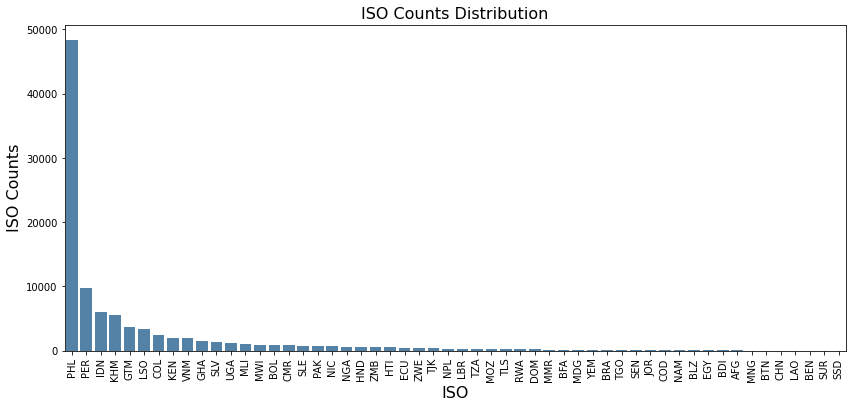

In [ ]:
#check unique values of ISO
#np.unique(mpi_reg_df['ISO'].tolist())
iso_counts=mpi_reg_df['ISO'].value_counts()
#plot
plot = plt.figure(figsize=(14,6))
sns.barplot(x = iso_counts.index, y=iso_counts.values, color='steelblue')
plt.xlabel('ISO', fontsize=16)
plt.ylabel("ISO Counts", fontsize=16)
plt.title("ISO Counts Distribution", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.show();

In [ ]:
iso_top = mpi_reg_df[['ISO','MPI']]
iso_top = iso_top.groupby(by=['ISO'], as_index=False).mean()
iso_top = iso_top.rename(columns={"MPI": "avg_MPI"})
iso_top_all = iso_top.sort_values(by='avg_MPI', ascending=False)
iso_top = iso_top_all.head(10)

plot the avg MPI in the top 10 countries with most counts.

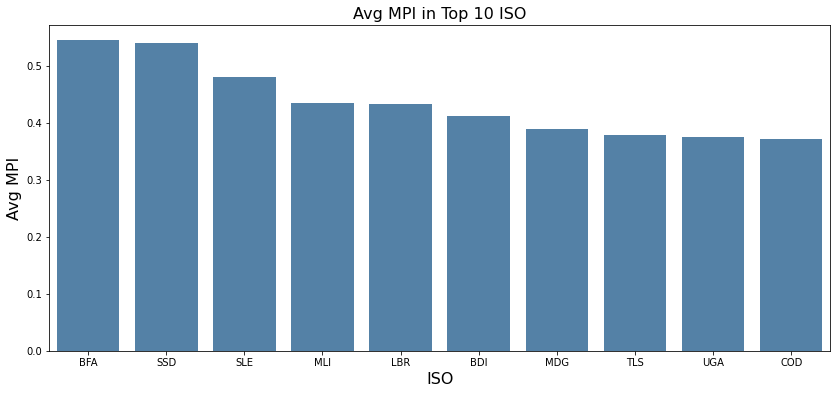

In [ ]:
#plot the avg MPI
plot = plt.figure(figsize=(14,6))
sns.barplot(x = 'ISO', y='avg_MPI', color='steelblue', data=iso_top)
plt.xlabel('ISO', fontsize=16)
plt.ylabel("Avg MPI", fontsize=16)
plt.title("Avg MPI in Top 10 ISO", fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.show();

In [ ]:
import plotly.express as px

df = px.data.gapminder().query("year==2007")
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
11,Afghanistan,Asia,2007,43.828,31889923,974.580338,AFG,4
23,Albania,Europe,2007,76.423,3600523,5937.029526,ALB,8
35,Algeria,Africa,2007,72.301,33333216,6223.367465,DZA,12
47,Angola,Africa,2007,42.731,12420476,4797.231267,AGO,24
59,Argentina,Americas,2007,75.320,40301927,12779.379640,ARG,32
...,...,...,...,...,...,...,...,...
1655,Vietnam,Asia,2007,74.249,85262356,2441.576404,VNM,704
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798,PSE,275
1679,"Yemen, Rep.",Asia,2007,62.698,22211743,2280.769906,YEM,887
1691,Zambia,Africa,2007,42.384,11746035,1271.211593,ZMB,894


Plot the average MPI in map

In [ ]:
import plotly.express as px

df = iso_top_all
fig = px.choropleth(df, locations="ISO",
                    color="avg_MPI", 
                    hover_name="ISO", 
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

###Loan Sector and Use

Let's examine the loans regarding their sector and use.

Let's see how many sectors are in the data.

In [ ]:
sectors = loans_df['sector']
sectors_total = sectors.value_counts()
sectors_total

Agriculture       180302
Food              136657
Retail            124494
Services           45140
Personal Use       36385
Housing            33731
Clothing           32742
Education          31013
Transportation     15518
Arts               12060
Health              9223
Construction        6268
Manufacturing       6208
Entertainment        830
Wholesale            634
Name: sector, dtype: int64

There are 15 sectors in this dataset, and we see how many loans are in each sector. Let's visualize it to get a better view.

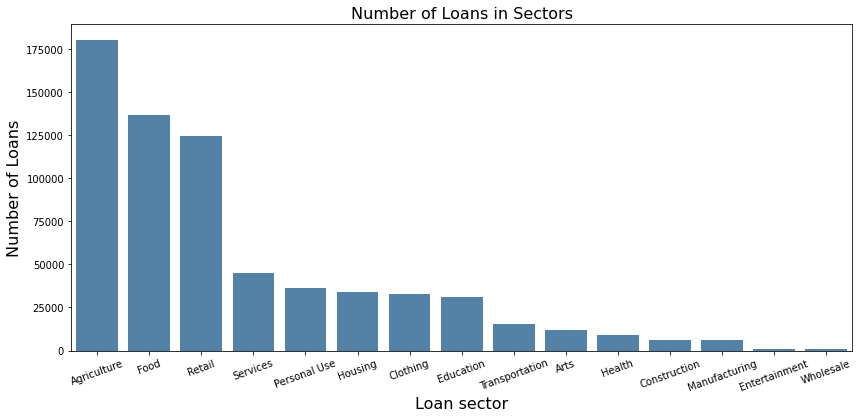

In [ ]:
plot = plt.figure(figsize=(14,6))
sns.barplot(x = sectors_total.index, y=sectors_total.values, color='steelblue')
plt.xlabel('Loan sector', fontsize=16)
plt.ylabel("Number of Loans", fontsize=16)
plt.title("Number of Loans in Sectors", fontsize=16)
plt.xticks(rotation=20, fontsize=10)
plt.show();

Now we see that Agriculture, Food, and Retail are among the most popular sectors for this Kiva loans dataset.
Then, we can use the use feature to see more exactly how are loans used.

Here is the use column of the loans_df, each recording a short description on the purpose of the loan.

In [ ]:
uses = loans_df['use']
uses_total = uses.value_counts();
uses_total.head(10)

to buy a water filter to provide safe drinking water for their family.    5217
to buy a water filter to provide safe drinking water for her family.      4082
To buy a water filter to provide safe drinking water for their family.    2141
to build a sanitary toilet for her family.                                1708
to build a sanitary toilet for her family                                 1599
to buy ingredients for her food production business                       1419
to purchase more groceries to sell.                                       1409
to buy feed and other supplies to raise her pigs.                         1405
to buy fertilizers and other farm supplies.                               1280
to buy a water filter to provide safe drinking water for his family.      1261
Name: use, dtype: int64

We get a brief overview of the usage of the loans, where **buying water filter**, **sanitation**, and **foods** are among the most popular purposes of loans. Since these are text description data, let's visualize them as a wordcloud to see how are loan uses distributed.

*Side-note: some of these uses are very similar, maybe we can group them with q-gram*

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# extract tokens from our use feature instances
def tokenize_content(content):
  words = nltk.word_tokenize(content, language='english')
  words = [word.lower() for word in words if (word.isalnum()) & (word.lower() not in stopwords)]
  return words

# take a random sample and tag the tokens to extract nouns, which would be most informative for loan uses
uses = loans_df['use'].sample(n=20000).dropna().to_list()
top_tokens_list = [nltk.pos_tag(tokenize_content(use)) for use in uses]

# count the occurance of tokens and save the top 20 most frequent nouns 
from nltk.collections import Counter
top_tokens = [token for tokens in top_tokens_list for (token, pos) in tokens if pos=='NN']
cnt = Counter()
for token in top_tokens:
  cnt[token]+=1
top_most_common = cnt.most_common(20)


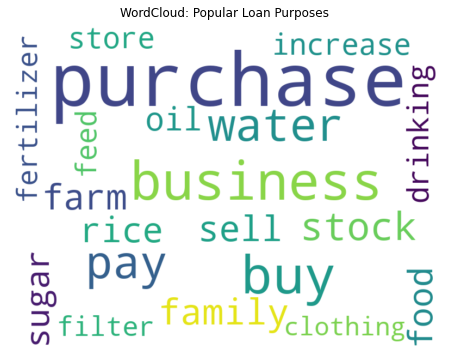

In [ ]:
# visualize with wordcloud
_ = plt.figure(figsize=(12,6))
cloud = WordCloud(width=800, height=600, background_color='White', contour_width=5).generate_from_frequencies(dict(top_most_common))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud: Popular Loan Purposes")
plt.show()

From the visualization, we can observe that most of the loan uses are associated with purchases and buying goods, while "farm", "water", "fertilizer" also corresponse with our earlier observation that Agriculture, Food, and Retail are the most popular domain of loan purposes.

## **Models**


In this section, we will apply Linear Regression, Logistic Regression, and Random Forest model to forecast the loan amount or loan amount class divided by loan amount.

### Regression Models


##### Linear Regression

###### Sample Linear Regression 

First, we will perform sample Linear regression to predict loan amount class divided by loan amount. When loan amount is greater than 800, we declare it as high loan amount. Otherwise, we declare the loan amount as low.

In [ ]:
loan_states_l = loan_stats_ml
loan_states_l['load_amount_class'] = np.where(loan_states_l['loan_amount'] > 800, 1.0, 0.0)

We choose load_amount_class as response variable and other factors as predict variables.

In [ ]:
linear_features = loan_states_l.drop(columns=['loan_amount','region_y','kiva_country_name'])
load_class = loan_states_l['load_amount_class']

We split the 80% of dataset into training set and 20% into test set.

In [ ]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(linear_features, load_class, random_state = seed, test_size = 0.2)

We perform linear regression base on training set.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
l_mod = LinearRegression().fit(x_train, y_train)
y_pred = l_mod.predict(x_test)

l_score = r2_score(y_test.values, y_pred)
l_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred))

print(f'R2 score is {round(l_score, 5)}.')
print(f'RMSE score is {round(l_rmse, 5)}.')

R2 score is 1.0.
RMSE score is 0.0.


The R2 score is 1, which means there is multicollinearity problem happened in the regression process. Now, we plot the correlation heatmap to check this.

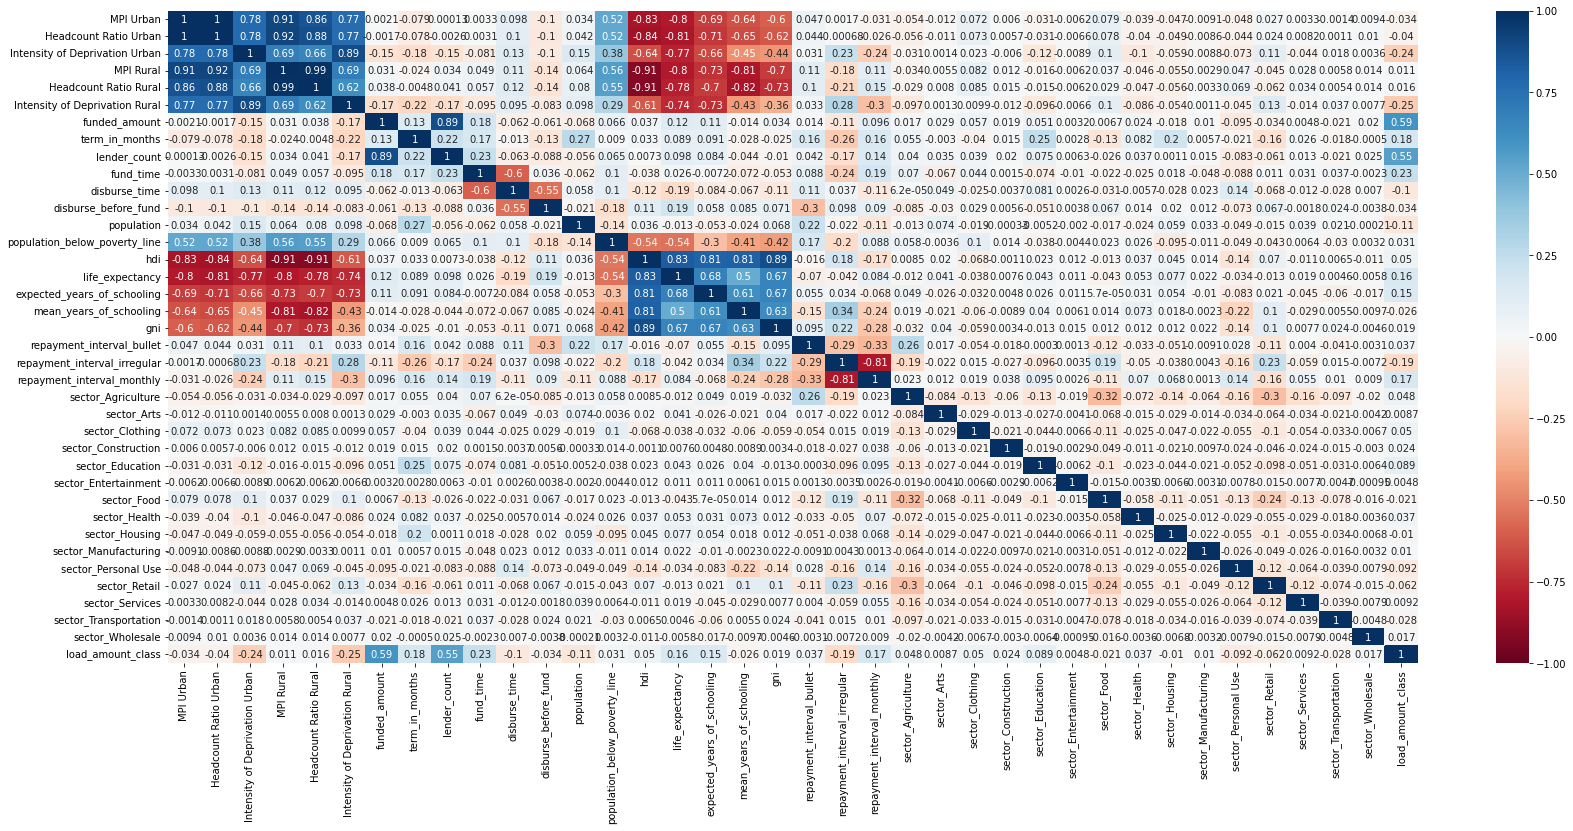

In [ ]:
plt.figure(figsize=(28,12))
corr_matrix = linear_features.corr()    
sns.heatmap(corr_matrix, cmap="RdBu",vmin=-1, vmax=1,annot=True)

The correlation heatmap indaticate that some factors are highly correlected with each other, therefore, we drop all the columns with high correlation.

In [ ]:
load_class_2 = loan_states_l['load_amount_class']
linear_features_2 = loan_states_l.drop(columns=['loan_amount','region_y','kiva_country_name','Headcount Ratio Urban','Intensity of Deprivation Urban','MPI Rural','Headcount Ratio Rural','Intensity of Deprivation Rural','funded_amount','life_expectancy','expected_years_of_schooling','mean_years_of_schooling','gni','hdi','repayment_interval_irregular','fund_time','disburse_time','disburse_before_fund'])

Plot the correlation matrix again.

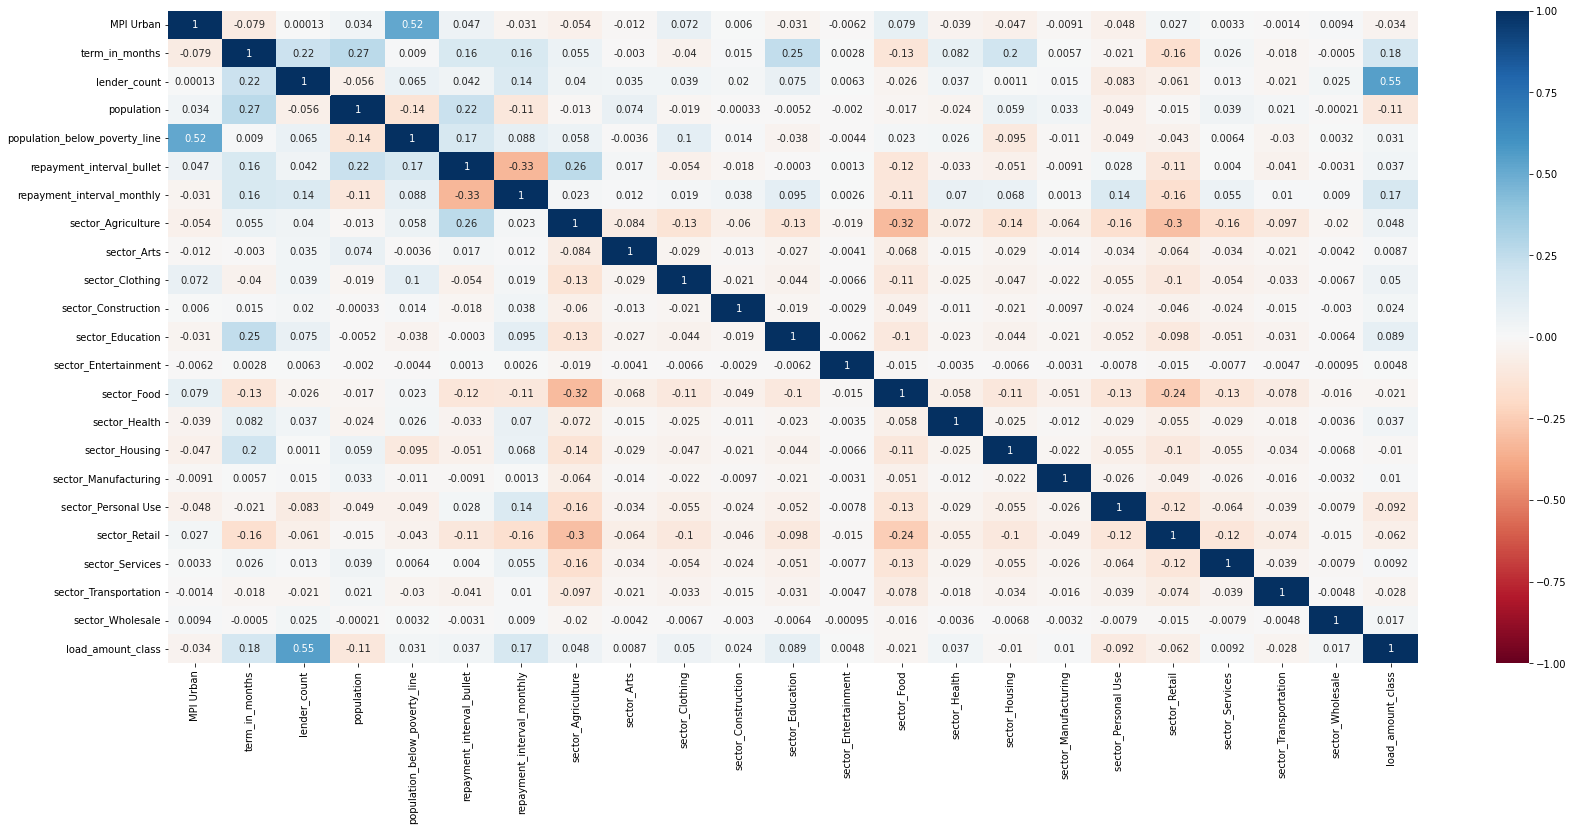

In [ ]:
plt.figure(figsize=(28,12))
corr_matrix = linear_features_2.corr()    
sns.heatmap(corr_matrix, cmap="RdBu",vmin=-1, vmax=1,annot=True)

Apply the sample linear regression again.

In [ ]:
seed = 42
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(linear_features_2, load_class_2, random_state = seed, test_size = 0.2)

In [ ]:
l_mod_2 = LinearRegression().fit(x_train_2, y_train_2)
y_pred_2 = l_mod_2.predict(x_test_2)

l_score_2 = r2_score(y_test_2.values, y_pred_2)
l_rmse_2 = np.sqrt(mean_squared_error(y_test_2.values, y_pred_2))

print(f'R2 score is {round(l_score_2, 5)}.')
print(f'RMSE score is {round(l_rmse_2, 5)}.')

R2 score is 1.0.
RMSE score is 0.0.


After drop columns with high correalation, there is still a overfitting issue. Then we apply PCA to solve this problem.

###### PCA

In [ ]:
scaler_r = StandardScaler()
x_train_r = scaler_r.fit_transform(x_train_2)
x_test_r = scaler_r.transform(x_test_2)

pca_r = PCA(n_components = x_train_2.shape[1])

pca_x_train_r = pca_r.fit_transform(x_train_r)
pca_r = PCA(n_components=x_train_r.shape[1])
x_train_pca_r = pca_r.fit_transform(x_train_r)


explained_variance_ratios=pca_r.explained_variance_ratio_
cum_evr=np.cumsum(pca_r.explained_variance_ratio_)
cum_evr

array([0.08565429, 0.15831386, 0.23016774, 0.28786013, 0.34409214,
       0.39764075, 0.44448703, 0.49067794, 0.53618997, 0.58096983,
       0.62542911, 0.66943323, 0.71341047, 0.75702814, 0.80055254,
       0.84345407, 0.88542281, 0.92071682, 0.94556575, 0.96632584,
       0.98532984, 1.        , 1.        ])

According to cum_evr, the first 17 components cover at least 80% of the varience.

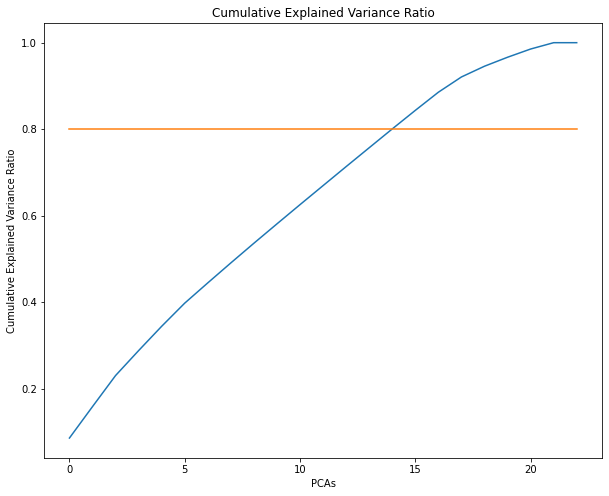

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, 23), np.cumsum(pca_r.explained_variance_ratio_))
plt.plot(np.arange(0, 23), [0.80]*23)

# Aesthetics (1 point for title AND both axes labels)
plt.xlabel("PCAs")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio")
plt.show()

Then we appply the sample linear regression with the first 17 PCs.

###### Linear Regression after PCA

In [ ]:
pca = PCA(n_components=15)
pca_x_train = pca.fit_transform(x_train_r)
x_test_pca = pca.transform(x_train_r)

In [ ]:
reg = LinearRegression()
reg.fit(pca_x_train, y_train_2)
y_pred = reg.predict(x_test_pca)
score=r2_score(y_train_2, reg.predict(x_test_pca))
score

0.7189214359838241

The result shows that the overfitting problem is still solved. But the R2 scorce is low. Only 72% of dependent data can be explained. 

Now, we apply Ridge Regression to try to solve the issue.

###### Ridge Regression

In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge
reg_ridge = Ridge(alpha = 10)
reg_ridge.fit(pca_x_train, y_train_2)
y_pred = reg_ridge.predict(x_test_pca)
ridge_score=r2_score(y_train_2, reg_ridge.predict(x_test_pca))
ridge_score

0.7189214358399949

The Ridge Regression does not help, the R2 is still low.

Then we try Lasso Regression

###### LASSO Regression

In [ ]:
from sklearn.linear_model import LassoCV, Lasso
lassocv = LassoCV()
lassocv.fit(pca_x_train, y_train_2)
lasso_select = lassocv.alpha_
lasso = Lasso(alpha=lasso_select)
lasso.fit(pca_x_train, y_train_2)
y_pred_lasso = lasso.predict(x_test_pca)

lasso_score=r2_score(y_train_2, reg_ridge.predict(x_test_pca))
lasso_score

0.7189214358399949

The Lasso Regression does not help to improve the R2 score.

In the next step, we will try to use Logistic Regression and Random Forest model with binary or multiclass response variable to see if there is any improve.

#####Logistic Regression

###### Binary Classification: Large vs Small Loan Amount

We are now switching into classification mode. We will be predicting whether the load_amount is high or low. As the loan amount range is around 700 to 1000. A high amount is defined as one where the amount is above 800 and low is one where the amount is less than or equal to 800. Reuse the loan_amount_class defined before which has 1.0 if the rating is high and 0.0 if the rating is low

In [ ]:
loan_states_log = loan_stats_ml
loan_states_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537083 entries, 0 to 537082
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MPI Urban                       537083 non-null  float64
 1   Headcount Ratio Urban           537083 non-null  float64
 2   Intensity of Deprivation Urban  537083 non-null  float64
 3   MPI Rural                       537083 non-null  float64
 4   Headcount Ratio Rural           537083 non-null  float64
 5   Intensity of Deprivation Rural  537083 non-null  float64
 6   funded_amount                   537083 non-null  float64
 7   loan_amount                     537083 non-null  float64
 8   term_in_months                  537083 non-null  float64
 9   lender_count                    537083 non-null  int64  
 10  fund_time                       537083 non-null  int64  
 11  disburse_time                   537083 non-null  int64  
 12  disburse_before_

Select appropriate features

In [ ]:
log_labels = loan_states_log['load_amount_class']
log_features = loan_states_log.drop(columns=['load_amount_class','loan_amount', 'region_y','kiva_country_name', 'funded_amount', 'term_in_months', 'repayment_interval_bullet', 'repayment_interval_irregular', 'repayment_interval_monthly', 'disburse_before_fund'])

Split the train and the test data

In [ ]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(log_features, log_labels, random_state = seed, test_size = 0.2)

###### PCA to Reduce Dimensionality

As a first step, instantiate and fit PCA from scikit-learn on the training set. We are not reducing the dimensionality of our data in this step but rather trying to find what would be the ideal number of Principal Components to choose. 

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)
pca = PCA(n_components=x_train_sc.shape[1])
pca_x_train = pca.fit_transform(x_train_sc)

Cumulative Explained Variance Ratios

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr=np.cumsum(pca.explained_variance_ratio_)

Now plot the cumulative explained_variance_ratio against the number of components to decide the number of components you should keep

Text(0.5, 1.0, 'optimal num components')

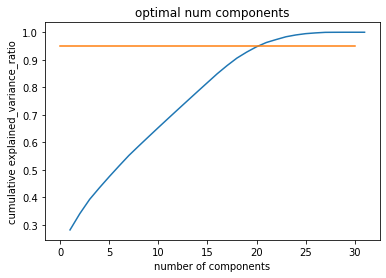

In [ ]:
plt.plot(np.arange(1,len(cum_evr)+1), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 31), [0.95]*31)

plt.xlabel("number of components")
plt.ylabel("cumulative explained_variance_ratio")
plt.title("optimal num components")

With PCA, we see that 20 features could be a good number of components to reach a good 90% explained variance. 

We will thus apply 20 components to our features:

In [ ]:
pca = PCA(n_components=20)
pca_x_train = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

###### Train the Model and test accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg_pca = LogisticRegression()
log_reg_pca.fit(pca_x_train, y_train)
y_pred = log_reg_pca.predict(x_test_pca)
test_accuracy = log_reg_pca.score(x_test_pca, y_test)
test_accuracy

0.9170429261662493

The accuracy is satisfying with 0.92. 

###Random Forest: Binary & Multi-Classfication
As our dataset is large and consists of numerous categorical and continuous features that ranges from economic measures to loan request details, Random Forest models could be an effective choice for us to learn from this mixture of features and tune for optimal results.

In this section, we will build random forest models to predict loan amount requested based on the borrower's information and conditions.

First, we will extract our label from the data set and summarize what features we would analyse on.

#### Binary Classification: Large vs. Small Loan Amount

Here is the distribution of loan amount that we are interested in. We can see while the loan demanded normally is around 700~1000, there are also loans with large amount. Let's use the 75% percentile as a boundary for a loan to be considered large. We will use random forest to examine the factors that make a loan to be considerably large.

In [ ]:
loan_stats_ml['loan_amount'].describe()

count    537083.000000
mean        689.805300
std         979.610313
min          25.000000
25%         250.000000
50%         425.000000
75%         800.000000
max      100000.000000
Name: loan_amount, dtype: float64

Let's create a label called large_demand, where 1 indicates that a loan is considered large, while 0 indicates otherwise.

In [ ]:
# set up binary classification label large_amount
loan_stats_ml['large_amount'] = loan_stats_ml['loan_amount'].apply(lambda x : 1 if x > 800 else 0)

In [ ]:
# set up label and select features (exclude non-numeric and correlated features)
rf_label = loan_stats_ml['large_amount']
rf_features = loan_stats_ml.select_dtypes(exclude=['datetime64','object']).drop(columns=['large_amount', 'load_amount_class','loan_amount', 'funded_amount'])

In [ ]:
rf_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537083 entries, 0 to 537082
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MPI Urban                       537083 non-null  float64
 1   Headcount Ratio Urban           537083 non-null  float64
 2   Intensity of Deprivation Urban  537083 non-null  float64
 3   MPI Rural                       537083 non-null  float64
 4   Headcount Ratio Rural           537083 non-null  float64
 5   Intensity of Deprivation Rural  537083 non-null  float64
 6   term_in_months                  537083 non-null  float64
 7   lender_count                    537083 non-null  int64  
 8   fund_time                       537083 non-null  int64  
 9   disburse_time                   537083 non-null  int64  
 10  disburse_before_fund            537083 non-null  int64  
 11  population                      537083 non-null  int64  
 12  population_below

#### PCA: Determine Number of Components

Recall from our observations in previous sections, we have some correlation in our data as welfare and economic measures often consists of similar information and overlap.

We would want to run PCA to minimize multicollinearity for more effective random forest model. Let's create a visualization of explained variance ratio with different number of components to see what number could be the most effective. Here, we wish to have a 90% explained variance ratio.

In [ ]:
# spliting the train and test data
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(rf_features, rf_label, test_size = 0.2, random_state = 100)

In [ ]:
# standardize features for pca
scaler = StandardScaler()
x_train_rf_sc = scaler.fit_transform(x_train_rf)
x_test_rf_sc = scaler.transform(x_test_rf)

In [ ]:
# fit data into pca
# here we want to have max n_component (i.e. number of all features) for observation
pca = PCA(n_components = x_train_rf_sc.shape[1])
pca_x_train_rf = pca.fit_transform(x_train_rf_sc)

# get the explained_variance_ratios and calculate cumulative value
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(pca.explained_variance_ratio_)

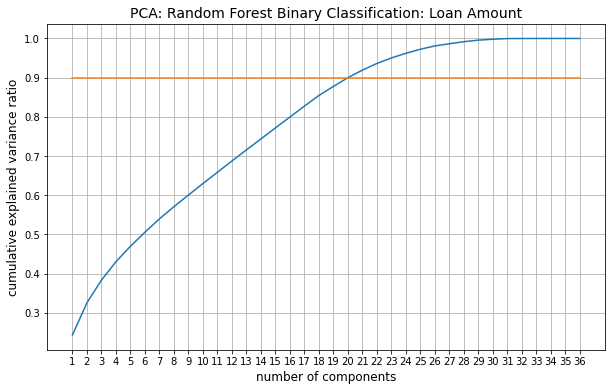

In [ ]:
# visualize pca and explained variance ratio
_ = plt.figure(figsize=(10,6))
_ = plt.plot(np.arange(1, 37), cum_evr)
_ = plt.plot(np.arange(1, 37), [0.90]*36)

_=plt.xlabel('number of components', fontsize=12)
_=plt.ylabel('cumulative explained variance ratio', fontsize=12)
_=plt.title('PCA: Random Forest Binary Classification: Loan Amount', fontsize=14)
_=plt.xticks(np.arange(1, 37, 1))
_=plt.grid()

With PCA, we see that 20 could be a good number of components to capture 90% explained variance:

In [ ]:
# pca with n components of 20
pca = PCA(n_components=20)
x_train_rf_pca = pca.fit_transform(x_train_rf)
x_test_rf_pca = pca.transform(x_test_rf)

Then, we can feed our random forest model.

In [ ]:
# train and test our binary classifier
rf_amount = RandomForestClassifier(n_estimators = 3, max_depth = 2)
rf_amount.fit(x_train_rf_pca, y_train_rf)
rf_preds = rf_amount.predict(x_test_rf_pca)
rf_accuracy = rf_amount.score(x_test_rf_pca, y_test_rf)
rf_accuracy

0.7586229367790945

####Binary Classification Assessment: Confusion Matrix
Now thought we have some decent model accuracy, let's examine the model's performance more with a confusion matrix.

In [ ]:
# import and fit our real and predicted data into confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_rf_df = pd.DataFrame(confusion_matrix(y_test_rf, rf_preds))

In [ ]:
plot = plt.figure(figsize=(12,6))
plot = sns.heatmap(data=confusion_matrix_rf_df, cmap='crest', annot=True, fmt='.0f')   
_ = plt.title("Confusion Matrix: Large Loan Amount", fontsize=16)
_ = plt.xlabel('Prediction', fontsize=14)
_ = plt.ylabel('Actual', fontsize=14)
_ = plt.xticks(np.arange(0.5,2.5,1), ['Non-Large', 'Large'], fontsize=12)
_ = plt.yticks(np.arange(0.5,2.5,1), ['Non-Large', 'Large'], fontsize=12, rotation=0)

NameError: ignored

The confusion matrix shows that our random forest model did a fair job on producing TP (Large) and TN (Non-Large) results. However, note that there are more false negative guesses, which is likely because of that there are more instances in the non-large category. We might need additional instances with larger loan amount to accommondate this bias, as the large imbalance between the classes might not be the most effectively solved with resampling alone, which could induce biases in our prediction.

#### Multiclass Classification: Level of Demand

This simple random forest generate some effective predictions on loan amount. Now, the other factor that could help to determine **how demanding a loan is** would be the loan themes. 

The sectors feature in the Kiva dataset represents the board categories of the purpose a loan request. 

In [ ]:
pd.unique(loan_stats_df['sector']).tolist()

['Transportation',
 'Arts',
 'Food',
 'Services',
 'Manufacturing',
 'Wholesale',
 'Retail',
 'Clothing',
 'Health',
 'Education',
 'Personal Use',
 'Agriculture',
 'Construction',
 'Entertainment',
 'Housing']

Here we may notice that the themes themselves may provide insights on how demanding a loan might be. 

For example, we could conclude that most loans in the *Food*, *Health*, *Education* sectors might be more demanding than other, let's say, *Arts* and *Entertainment* sectors.

Based on the sectors and together with loan amount, we could construct a **multiclass label** that indicates the level of demandness of a loan.

**Here we would add a label to our data called high_demand which:**
- is 4 for any loans in sectors Food and Health.
- is 3 for any loans in sectors education, clothing, housing.
- is 2 for any loans in the other sectors where large_amount = 1.
- is 1 for any loans in the in the other sectors where large_amount = 0.

In [ ]:
# initialize the column with 1 as default
loan_stats_ml['high_demand'] = 1

# populate the score correspondingly
loan_stats_ml.loc[loan_stats_ml['large_amount']==1, 'high_demand'] = 2
loan_stats_ml.loc[((loan_stats_ml['sector_Education']==1) | (loan_stats_ml['sector_Clothing']==1)\
                    | (loan_stats_ml['sector_Housing']==1)), 'high_demand'] = 3
loan_stats_ml.loc[((loan_stats_ml['sector_Food']==1) | (loan_stats_ml['sector_Health']==1)), 'high_demand'] = 4

Now we can use high demand as a label and learn the data with random forest. Let's re-select the features and do the modeling.

In [ ]:
# set up label and features for demand level model
rf_label_d = loan_stats_ml['high_demand']
rf_features_d = rf_features.drop(rf_features.filter(regex='sector').columns, axis=1)

In [ ]:
# spliting the train and test data
x_train_rf_d, x_test_rf_d, y_train_rf_d, y_test_rf_d = train_test_split(rf_features_d, rf_label_d, test_size = 0.2, random_state = 100)

#### PCA: Determine Number of Components

In [ ]:
# standardize our features for PCA
scaler = StandardScaler()

x_train_rf_d_sc = scaler.fit_transform(x_train_rf_d)
x_test_rf_d_sc = scaler.transform(x_test_rf_d)

pca_d = PCA(n_components = x_train_rf_d_sc.shape[1])
pca_x_train_rf_d = pca_d.fit_transform(x_train_rf_d_sc)

In [ ]:
# get accumulative explained variance ratio
explained_variance_ratios_d = pca_d.explained_variance_ratio_
cum_evr_d = np.cumsum(explained_variance_ratios_d)

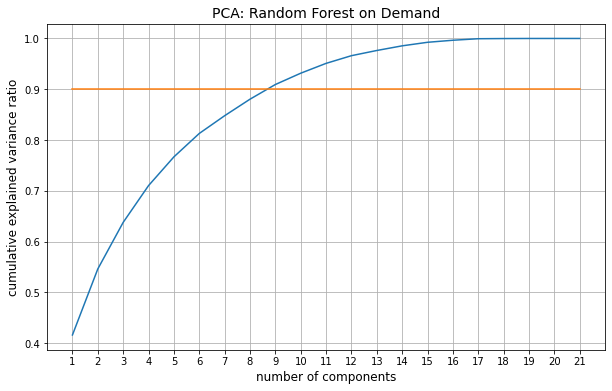

In [ ]:
_ = plt.figure(figsize=(10,6))
_ = plt.plot(np.arange(1, 22), cum_evr_d)
_ = plt.plot(np.arange(1, 22), [0.90]*21)
_=plt.xlabel('number of components', fontsize=12)
_=plt.ylabel('cumulative explained variance ratio', fontsize=12)
_=plt.title('PCA: Random Forest on Demand', fontsize=14)
_=plt.xticks(np.arange(1, 22, 1))
_=plt.grid()

We see that 9 could be a good number of components to capture 90% explained variance. 

Then, let's use 9 pca components for our features.

In [ ]:
# run pca with n components of 9
pca = PCA(n_components=9)
x_train_rf_d_pca = pca.fit_transform(x_train_rf_d)
x_test_rf_d_pca = pca.transform(x_test_rf_d)

Then, we can feed our random forest model.

In [ ]:
# train and test our multiclass random forest model
rf_demand = RandomForestClassifier(n_estimators = 3, max_depth = 2)
rf_demand.fit(x_train_rf_d_pca, y_train_rf_d)
rf_preds_d = rf_demand.predict(x_test_rf_d_pca)
rf_accuracy_d = rf_demand.score(x_test_rf_d_pca, y_test_rf_d)
rf_accuracy_d

0.5071729800683318

It is noticeable that the result of the model does not seem very appealing. Though, in fact, our model seems to have random accuracy ranging from around 55%-67%.

While it might be that our features are not very effective predictors of demand level of a loan, it is also possible that there are too few estimators or depth in our model that caused the accuracy to be less stable.

Next, we will do some hyperparameter tuning on our model to decide how many estimators to include to improve accuracy but avoid overfitting.

In [ ]:
# set arrays to record different numbers of estimator, depth, and corresponding accuracy
n_est_arr = []
n_depth_arr = []
accuracy_arr = []

# loop over increasing numbers of estimator and depth to get accuracy
for n_est in range(1, 16, 3):
  for n_depth in range(1, 12, 2):
    rf_tuning = RandomForestClassifier(n_estimators = n_est, max_depth = n_depth)
    rf_tuning.fit(x_train_rf_d, y_train_rf_d)
    accuracy_tuning = rf_tuning.score(x_test_rf_d, y_test_rf_d)
    n_est_arr.append(n_est)
    n_depth_arr.append(n_depth)
    accuracy_arr.append(accuracy_tuning)

# map the accuracies into a 2d array for visualization
accuracy_mat = [[0]*6 for i in range(5)]
for i in range(5):
  for j in range(6):
    accuracy_mat[i][j] = accuracy_arr[6*i+j]

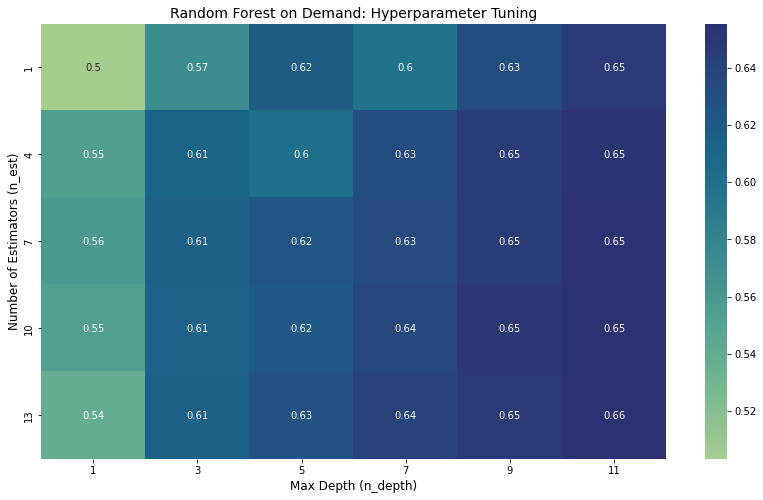

In [ ]:
plt.figure(figsize=(14,8))
sns.heatmap(accuracy_mat, cmap="crest",annot=True, \
            yticklabels=np.arange(1, 16, 3), xticklabels=np.arange(1, 12, 2))
_=plt.xlabel('Max Depth (n_depth)', fontsize=12)
_=plt.ylabel('Number of Estimators (n_est)', fontsize=12)
_=plt.title('Random Forest on Demand: Hyperparameter Tuning', fontsize=14)

Through the visualization, we see that accuracy is quite low with 1-2 estimators, but quickly saturates with more estimators and depth. This could be a result from that too few estimators depended to much on the random samples of the data that caused very low accuracy. 

Also note that with max_depth larger than 5, we could reach 100% accuracy, which seems to be overfitting. It seems that just having ~10 estimators with a depth of 3 could improve our model.

Here, we tune our model based on the observation:

In [ ]:
# set our model again with observation on hyperparameter
rf_demand = RandomForestClassifier(n_estimators = 7, max_depth = 7)
rf_demand.fit(x_train_rf_d, y_train_rf_d)
rf_preds_d = rf_demand.predict(x_test_rf_d)
rf_accuracy_d = rf_demand.score(x_test_rf_d, y_test_rf_d)
rf_accuracy_d

0.6334192911736504

We can evaluate the stability of our model by running it a few more times and compare our results.



In [ ]:
# set and train our improved model in an iteration of 12 to observe its stability
rf_accuracy_d_arr = []
for i in range(12):
  rf_demand = RandomForestClassifier(n_estimators = 7, max_depth = 7)
  rf_demand.fit(x_train_rf_d, y_train_rf_d)
  rf_preds_d = rf_demand.predict(x_test_rf_d)
  rf_accuracy_d = rf_demand.score(x_test_rf_d, y_test_rf_d)
  rf_accuracy_d_arr.append(rf_accuracy_d)
print("Random forst model on demand with %d estimators and %d maxdepth produces %.2f%% minimum and %.2f%% maximum accuracy "\
      % (10, 3, min(rf_accuracy_d_arr)*100, max(rf_accuracy_d_arr)*100))

Random forst model on demand with 10 estimators and 3 maxdepth produces 63.48% minimum and 63.93% maximum accuracy 


It might be noticeable that our accuracy still fluctuates, but in a higher and narrower range than our initial random forest model.

####Model Assessment: Confusion Matrix
Now that we have some decent model accuracy, let's further analyse how our random forest model performs with confusion matrix.

In [ ]:
# import and use actual and predicted data to produce confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_d_df = pd.DataFrame(confusion_matrix(y_test_rf_d, rf_preds_d))

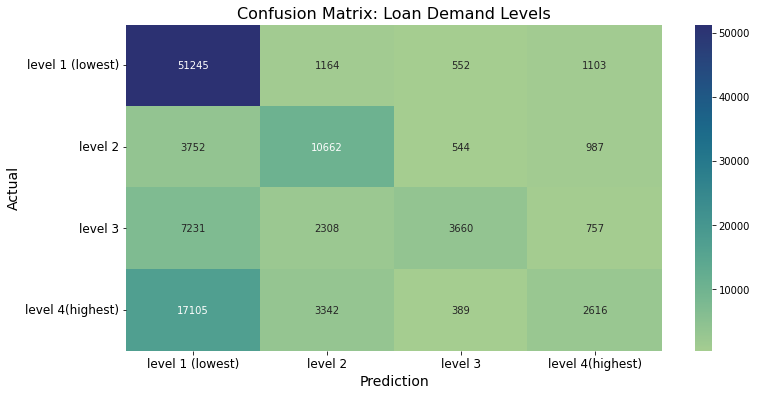

In [ ]:
# visualization
plot = plt.figure(figsize=(12,6))
plot = sns.heatmap(data=confusion_matrix_d_df, cmap='crest', annot=True, fmt='.0f')   
_ = plt.title("Confusion Matrix: Loan Demand Levels", fontsize=16)
_ = plt.xlabel('Prediction', fontsize=14)
_ = plt.ylabel('Actual', fontsize=14)
_ = plt.xticks(np.arange(0.5,4.5,1), ['level 1 (lowest)', 'level 2', 'level 3', 'level 4(highest)'], fontsize=12)
_ = plt.yticks(np.arange(0.5,4.5,1), ['level 1 (lowest)', 'level 2', 'level 3', 'level 4(highest)'], fontsize=12, rotation=0)

From the confusion matrix we can observe that our model perform effective on predictions of the 2nd and 3rd level of loan demand to some extent, while notice that there is a lot of false positive predictions for level 1.

Recall that we observed in the earlier binary classifier section a similar behavior, that our model tend to give false predictions for level 1. This shared behavior indicates that our data may lack information that would improve our model's performance on distinguishing between a proportion of low demand and high demand instances.

Nevertheless, we can observe from the confusion matrix that, though with a considerable number of false prediction, our model also sucessfully produce a decent number of true positive predictions. Though we might not be able to improve our dataset immediately, our analysis provides informative insight of possible improvements.

##Conslusion

###EDA
EDA really allowed us to investigate and get insights into the interesting questions about the data while also gaining some much needed familiarity with the datasets in general.

Through our various visualizations, we are able to see the distribution of various attributes for the crowdfunding serivce.



*   From distribution of loan amount, we can see that the majority of the loans concentrate on the range(700, 1000), which provides the foundation for the later classification 
*   From the Country Counts Distribution, we can see the top aggregate country counts
*   From the Avg Funded Amount by country, we visualization the top 10 country with the highest Avg Funded Amount
*   From the Repayment Interval Distrubution, we can see more than half of the loan is paid monthly, while others are with irregular and bullet repayment interval
*   From the Avg MPI, ISO counts Distribution and ISO distribution map, we can tell that the country with high number of loan tends to have high MPI, indicating MPI is a good feature for future analysis
*  From the number of loans in sectors, we can see that the top sectors for loan usage concentrate around the Agriculture, Food. 




## Modeling

#### Linear Regression

The Linear Regression models are overfitting. After trying to drop columns and apply PCA with indicates that there should not be any correlation between the predict variables and response variable, the models are not overfitted. However, the R2 is only 0.72 which means only 72% of dependent data can be explained. Then we try Ridge and LASSO Regression, but they did not help.

In this case, we need to apply Logistic Regression and Random Forest model instead.

#### Logistic Regression
The Logistic Regression Model performs well with the accuracy of 0.917. As the linear model, it defines the threshold for the classification as first. Then, from the experience, It is supposed that several features might have high multicollinearity, so we apply PCA. And according to the intersection of the num of features and explained_variance_ratio, we have determined n is equal to 20. We then reapply the PCA to the train and test data. At the last, we train and test the accuracy

####Random Forest Classifiers

Our random forest Bianry Classifier shows mediocore results and performance on predicting whether a loan is significantly large in amount, with an accuracy of ~0.73. It shows a lower accuracy than that of our logistic model. It might provide some limited validation between our models in this way. It may not provide the prediction in a sense of probability like our logistic regression model, meaning a less adjustable boundary between the classes of low and large loan amounts. However, its malperformance should be a result of an imbalance of the classes, and it indicates a need for more instances that are larger in amount for an improved performance.

Our multiclass random forest classifier, on the other hand, shows a some suboptimal performance of fluctuating accuracies of around 0.63~0.70. Though, it might be reasonable in respect to fact that our 4-level demand label could be complicated and affected by multiple features, especially between the lowest and highest demand levels that has the majority of instances in our data. It may also imply that we might need to incorporate more diversed data to provide more extensive information that would help our multiclassification model to learn better. 

Nevertheless, our random forest classifier would be the most effective and appropriate among our models in predictions involving loan purposes, which is one of the most important aspect of our analysis.



##Potential Next Steps



*   Explore more rows of latest data to do the time-series inflation analysis and incorporate it to the loan amount. Because the amount of the loan might be greatly affected by the inflation, we need to reduce its impact when training the model and apply it back when predicting the actual result.  

*   To include more features and data if possible. Since the current linear model has the problem of overfit and we currently only have 20-30 features. More features would furture improve the hyperparameter tuning and train better models.

*   When computational ability allows, use the Feedforward Neutral Net Classifiers and do the hyperparameter tuning. For this project, due to the limit of the CPU and GPU ability, the import of the required package mxnet always failed. So we don't have the chance to use this model for the report.







